In [6]:
from pytorch_ood.model import WideResNet
from tqdm import tqdm
import torch
import numpy as np

In [7]:
# fix ssl certificate issue
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
# get device
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU for computations.")
        return torch.device('cuda')
    else:
        print("CUDA is not available. Using CPU for computations.")
        return torch.device('cpu')

device = get_device()

# load model
model = WideResNet(num_classes=10, pretrained="cifar10-pt").to(device).eval()
print("Model loaded.")


import torchvision.transforms as trn
from pytorch_ood.utils import ToRGB
import torchvision.datasets as dset
from pytorch_ood.dataset.img import TinyImages300k
import pytorch_ood

def get_transforms(dataset_name, img_size=32):
    resize = trn.Resize((img_size, img_size))

    if dataset_name == "cifar10":
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
    elif dataset_name == "cifar100":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    elif dataset_name == "imagenet":
        transform = trn.Compose([
                trn.Resize(256),
                trn.CenterCrop(224),
                ToRGB(),
                trn.ToTensor(),
                trn.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        return transform, transform
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    transform = trn.Compose([
        trn.RandomHorizontalFlip(),
        trn.RandomCrop(img_size, padding=4),
        trn.ToTensor(),
        trn.Normalize(mean, std)
    ])

    test_transform = trn.Compose([
        trn.ToTensor(),
        trn.Normalize(mean, std),
        resize
    ])

    return transform, test_transform

def create_data_loader(data, batch_size, shuffle, num_workers=0, pin_memory=True):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle,
                                       num_workers=num_workers, pin_memory=pin_memory)


def prepare_data_loaders():
    train_transform, _ = get_transforms("cifar10",32)
    train_data_in = dset.CIFAR10('../datasets', train=True, transform=train_transform, download=True)

    train_data_out = TinyImages300k(root="../datasets", transform=train_transform,
                                        target_transform=pytorch_ood.utils.ToUnknown(), download=True)

    # Define data loaders
    train_loader_in = create_data_loader(train_data_in, 64, shuffle=False)
    train_loader_out = create_data_loader(train_data_out, 64, shuffle=False)

    print(train_data_in[0])
    # shapoe
    print(train_data_in[0][0].shape)

    return train_loader_in, train_loader_out


inlier_loader, outlier_loader = prepare_data_loaders()

CUDA is available. Using GPU for computations.
Model loaded.
Files already downloaded and verified
(tensor([[[-0.3743, -0.1998, -0.1610,  ..., -2.4291, -2.4291, -2.4291],
         [ 0.0328, -0.0253, -0.0835,  ..., -2.4291, -2.4291, -2.4291],
         [ 0.0716,  0.2073,  0.1104,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-1.1792, -1.0416, -0.9629,  ..., -2.4183, -2.4183, -2.4183],
         [-0.8646, -0.9039, -0.9039,  ..., -2.4183, -2.4183, -2.4183],
         [-0.8056, -0.6876, -0.7662,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-1.675

In [8]:
for in_set, out_set in tqdm(zip(inlier_loader, outlier_loader), total=len(inlier_loader)):
    # define variables
    inlier = in_set[0].to(device)
    outlier = out_set[0].to(device)
    # set requires_grad to true
    inlier.requires_grad = True
    outlier.requires_grad = True

    # define target
    target_inlier = in_set[1].to(device)
    target_outlier = out_set[1].to(device)

    images_concat = torch.cat((inlier, outlier), 0).to(device)
    outputs_complete = model(images_concat)
    energy_complete = -torch.logsumexp(outputs_complete, dim=1)

    for i in tqdm(range(1)):
        images_concat = torch.cat((inlier, outlier), 0).to(device)

        outputs_complete = model(images_concat)
        outputs = model(outlier)

        # Calculate energy
        energy = -torch.logsumexp(outputs, dim=1)


        # Calculate energy for inlier and outlier
        energy_inlier = energy_complete[:len(inlier)]
        energy_outlier = energy

        # calculate mean
        mean_inlier = torch.mean(energy_inlier)
        mean_outlier = torch.mean(energy_outlier)

        # print("mean inlier: ", mean_inlier)
        # print("mean outlier: ", mean_outlier)

        # Calculate gradients of model energy
        grad_energy = torch.autograd.grad(mean_outlier, outlier,
                                          retain_graph=False, create_graph=False)[0]

        new_outlier = outlier - 0.04 * torch.sign(grad_energy)
        adv_img = torch.cat((inlier, new_outlier), 0).to(device)

        outputs_adv = model(adv_img)

        energy_adv = -torch.logsumexp(outputs_adv, dim=1)[len(inlier):]


        # comparison with high eps
        new_outlier_high = outlier - 0.5 * torch.sign(grad_energy)
        adv_img_high  = torch.cat((inlier, new_outlier_high), 0).to(device)

        outputs_adv_high  = model(adv_img_high )

        energy_adv_high  = -torch.logsumexp(outputs_adv_high , dim=1)[len(inlier):]

    break


# print(outlier[0])
# print(new_outlier[0])


  0%|          | 0/782 [00:00<?, ?it/s]


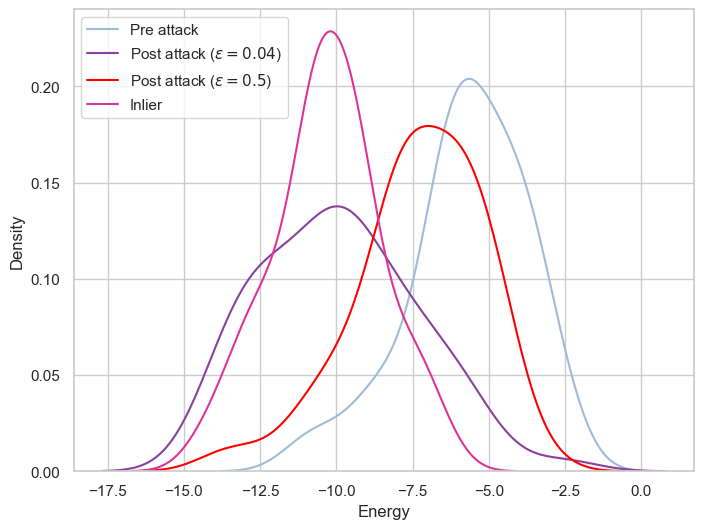

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

data_pre = energy_outlier.detach().cpu().numpy()
data_post = energy_adv.detach().cpu().numpy()
data_post_high = energy_adv_high.detach().cpu().numpy()
data_inlier = energy_inlier.detach().cpu().numpy()

# Assuming you have data_pre and data_post as NumPy arrays

# Calculate the mean of data_pre and data_post
mean_pre = np.mean(data_pre)
mean_post = np.mean(data_post)
mean_inlier = np.mean(data_inlier)

# Create a figure and axis object
plt.figure(figsize=(8,6))
# Create histograms using Seaborn

# kde plot
sns.kdeplot(data_pre, color='#9ebcda', alpha=1, label="Pre attack")
sns.kdeplot(data_post, color='#88419d', alpha=1, label="Post attack ($\\epsilon = 0.04$)")
sns.kdeplot(data_post_high, color='red', alpha=1, label="Post attack ($\\epsilon = 0.5$)")
sns.kdeplot(data_inlier, color='#dd3497', alpha=1, label="Inlier")

plt.xlabel('Energy')
plt.ylabel('Density')
# plt.title('Histogram of Data')
plt.legend()
plt.grid(True)

plt.savefig("plots/adversarial_energy.pdf")
# Show the plot
plt.show()


In [3]:
# load the file datasets/samples-0.0.npz as pytorch dataset
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Load npz file
data = np.load('datasets/samples-0.0.npz')

# Convert numpy arrays to PyTorch tensors
inputs = torch.from_numpy(data['x'])
targets = torch.from_numpy(data['y'])

# Create PyTorch dataset
dataset = TensorDataset(inputs, targets)

In [5]:
print(dataset[0])

(tensor([[[ 30,  35,  47,  ...,  28,  21,  22],
         [ 37,  53,  70,  ...,  24,  17,  16],
         [ 41,  40,  48,  ...,  12,  11,  11],
         ...,
         [ 93,  97, 104,  ..., 117, 107, 109],
         [ 98, 107, 103,  ..., 116, 109, 108],
         [102, 104, 105,  ..., 119, 108, 116]],

        [[ 47,  55,  67,  ...,  51,  41,  38],
         [ 67,  86,  99,  ...,  45,  36,  36],
         [ 72,  68,  76,  ...,  24,  23,  24],
         ...,
         [129, 124, 129,  ..., 154, 147, 151],
         [138, 134, 127,  ..., 154, 155, 156],
         [135, 136, 133,  ..., 159, 156, 151]],

        [[ 14,  18,  26,  ...,  28,  22,  19],
         [ 22,  32,  40,  ...,  26,  21,  19],
         [ 28,  23,  25,  ...,  13,  12,  12],
         ...,
         [ 52,  54,  55,  ...,  72,  65,  60],
         [ 53,  63,  54,  ...,  67,  58,  56],
         [ 55,  55,  53,  ...,  65,  60,  63]]], dtype=torch.uint8), tensor(4))


In [15]:
# load the file dtasets/samples-c10.pth as pytorch dataset
import torch
from torch.utils.data import Dataset

c10 = torch.load('datasets/samples-c10.pt')

In [22]:
dataset[0][0].shape

torch.Size([3, 32, 32])

In [18]:
c10.shape

torch.Size([50000, 3, 32, 32])

In [23]:
dataset[0]

(tensor([[[ 30,  35,  47,  ...,  28,  21,  22],
          [ 37,  53,  70,  ...,  24,  17,  16],
          [ 41,  40,  48,  ...,  12,  11,  11],
          ...,
          [ 93,  97, 104,  ..., 117, 107, 109],
          [ 98, 107, 103,  ..., 116, 109, 108],
          [102, 104, 105,  ..., 119, 108, 116]],
 
         [[ 47,  55,  67,  ...,  51,  41,  38],
          [ 67,  86,  99,  ...,  45,  36,  36],
          [ 72,  68,  76,  ...,  24,  23,  24],
          ...,
          [129, 124, 129,  ..., 154, 147, 151],
          [138, 134, 127,  ..., 154, 155, 156],
          [135, 136, 133,  ..., 159, 156, 151]],
 
         [[ 14,  18,  26,  ...,  28,  22,  19],
          [ 22,  32,  40,  ...,  26,  21,  19],
          [ 28,  23,  25,  ...,  13,  12,  12],
          ...,
          [ 52,  54,  55,  ...,  72,  65,  60],
          [ 53,  63,  54,  ...,  67,  58,  56],
          [ 55,  55,  53,  ...,  65,  60,  63]]], dtype=torch.uint8),
 tensor(4))